## Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

# Standard libraries
from pathlib import Path
import pprint

# Third-party libraries
import duckdb
import fireducks.pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib import rcParams
from matplotlib.lines import Line2D

from sklearn.covariance import EmpiricalCovariance, MinCovDet

rcParams["text.usetex"] = True

# Custom osbad library for anomaly detection
import osbad.config as bconf
import osbad.modval as modval
import osbad.viz as bviz
from osbad.database import BenchDB
from osbad.model import ModelRunner

# importing distance based anomaly detection utilities
from osbad import dbad

## Import Dataset

### Define Filepath

In [2]:
# Define a global variable to save fig output
# The definition of PIPELINE_OUTPUT_DIR can be
# found in config.py
PIPELINE_OUTPUT_DIR = bconf.PIPELINE_OUTPUT_DIR

In [3]:
# Load only the training dataset
db_filepath = str(
    Path.cwd()
    .parent
    .joinpath("database","train_dataset_severson.db"))

### Get cell inventory of training dataset

In [4]:
# Create a DuckDB connection
con = duckdb.connect(
    db_filepath,
    read_only=True)

# Load all training dataset from duckdb
df_duckdb = con.execute(
    "SELECT * FROM df_train_dataset_sv").fetchdf()

unique_cell_index_train = df_duckdb["cell_index"].unique()
print(unique_cell_index_train)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

['2017-05-12_5_4C-50per_3C_CH13' '2017-05-12_5_4C-50per_3C_CH14'
 '2017-05-12_5_4C-60per_3C_CH15' '2017-05-12_5_4C-60per_3C_CH16'
 '2017-05-12_5_4C-70per_3C_CH17' '2017-05-12_5_4C-70per_3C_CH18'
 '2017-05-12_6C-40per_3C_CH25' '2017-05-12_6C-40per_3C_CH26'
 '2017-05-12_6C-50per_3C_CH27' '2017-05-12_6C-50per_3C_CH28'
 '2017-05-12_6C-60per_3C_CH29' '2017-05-12_6C-60per_3C_CH30'
 '2017-05-12_7C-40per_3C_CH37' '2017-05-12_7C-40per_3C_CH38'
 '2017-05-12_4C-80per_4C_CH5' '2017-05-12_4C-80per_4C_CH6'
 '2017-05-12_4_4C-80per_4_4C_CH7' '2017-05-12_5_4C-80per_5_4C_CH11'
 '2017-05-12_5_4C-80per_5_4C_CH12' '2017-05-12_3_6C-80per_3_6C_CH1'
 '2017-05-12_3_6C-80per_3_6C_CH2' '2017-05-12_3_6C-80per_3_6C_CH3'
 '2017-05-12_5_4C-40per_3_6C_CH19']


In [5]:
training_cell_count = len(unique_cell_index_train)
print(f"Training cell count: {training_cell_count}")

Training cell count: 23


### Select a cell label

In [6]:
# Get the cell-ID from cell_inventory
selected_cell_label = "2017-05-12_5_4C-70per_3C_CH17"

# Create a subfolder to store fig output 
# corresponding to each cell-index
selected_cell_artifacts =  PIPELINE_OUTPUT_DIR.joinpath(
    selected_cell_label)

### Load benchmarking dataset and drop labels

In [7]:
# Import the BenchDB class
# Load only the dataset based on the selected cell
benchdb = BenchDB(
    db_filepath,
    selected_cell_label)

# load the benchmarking dataset
df_selected_cell = benchdb.load_benchmark_dataset(
    dataset_type="train")

if df_selected_cell is not None:

    filter_col = [
        "cell_index",
        "cycle_index",
        "discharge_capacity",
        "voltage"]

    # Drop true labels from the benchmarking dataset
    # and filter for selected columns only
    df_selected_cell_without_labels = benchdb.drop_labels(
        df_selected_cell,
        filter_col)
    
    # print a subset of the dataframe
    # for diagnostics running in terminals
    print(df_selected_cell_without_labels.head(10).to_markdown())
    print("*"*100)

Database is found in the given filepath.
Loading benchmarking dataset now...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

****************************************************************************************************
|    | cell_index                    |   cycle_index |   discharge_capacity |   voltage |
|---:|:------------------------------|--------------:|---------------------:|----------:|
|  0 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          1.26512e-05 |   3.29189 |
|  1 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00136774  |   3.28185 |
|  2 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00292998  |   3.27788 |
|  3 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00449361  |   3.27513 |
|  4 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00449361  |   3.27513 |
|  5 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00605927  |   3.27299 |
|  6 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00762155  |   3.27124 |
|  7 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.0091859   |   3.2703  |

### Plot cycle data without labels

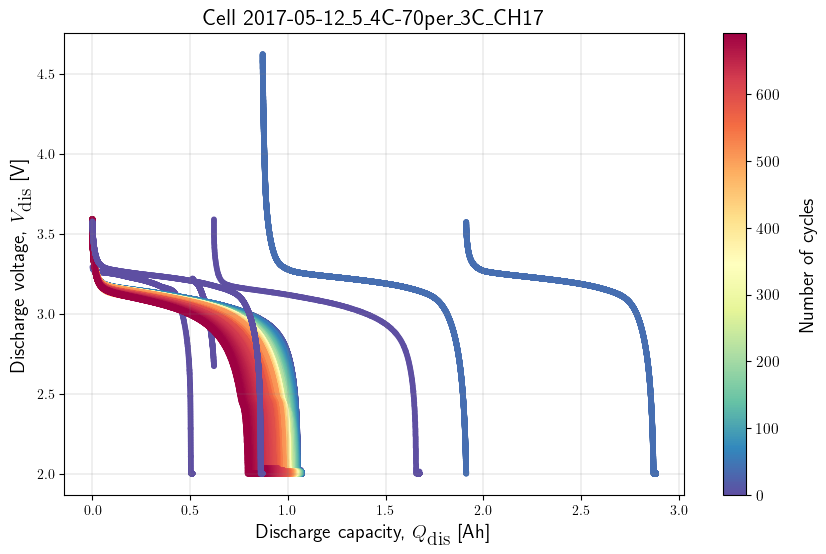

In [8]:
# If the true outlier cycle index is not known,
# cycling data will be plotted without labels
benchdb.plot_cycle_data(
    df_selected_cell_without_labels)

## Features transformation

### Load the training features dataset

In [9]:
# Define the filepath to ``train_features_severson.db``
# DuckDB instance.
db_features_filepath = (
    Path.cwd()
    .parent
    .joinpath("database","train_features_severson.db"))

# Load only the training features dataset
df_features_per_cell = benchdb.load_features_db(
    db_features_filepath,
    dataset_type="train")
print(df_features_per_cell.head(10).to_markdown())
print("*"*100)

unique_cycle_count = (
    df_features_per_cell["cycle_index"].unique())

Features database is found in the given filepath.
Features database is loaded.
****************************************************************************************************
|    |   max_diff_dQ |   log_max_diff_dQ |   cycle_index |   max_diff_dV |   log_max_diff_dV | cell_index                    |
|---:|--------------:|------------------:|--------------:|--------------:|------------------:|:------------------------------|
|  0 |    0.00638794 |          -5.05334 |             0 |     1.56415   |          0.447343 | 2017-05-12_5_4C-70per_3C_CH17 |
|  1 |    0.00633758 |          -5.06126 |             1 |     0.0237265 |         -3.74116  | 2017-05-12_5_4C-70per_3C_CH17 |
|  2 |    0.00632072 |          -5.06392 |             2 |     0.0226841 |         -3.78609  | 2017-05-12_5_4C-70per_3C_CH17 |
|  3 |    0.00625887 |          -5.07376 |             3 |     0.0278988 |         -3.57917  | 2017-05-12_5_4C-70per_3C_CH17 |
|  4 |    0.00623644 |          -5.07735 |             4 |

# Mahalanobis Distance

In [10]:
selected_feature_cols = (
    #"cycle_index",
    "log_max_diff_dQ",
    "log_max_diff_dV")

runner = ModelRunner(
        cell_label=selected_cell_label,
        df_input_features=df_features_per_cell,
        selected_feature_cols=selected_feature_cols)

features = runner.create_model_x_input()

#features = Xdata[:,1:]
#cycle_idx = Xdata[:,0]
#centroid = np.median(features, axis=0)

# cov_matrix = np.cov(features.T)
# inv_cov_matrix = np.linalg.inv(cov_matrix)

        
MCD = MinCovDet().fit(features)
#EC = EmpiricalCovariance().fit(features)
cov_matrix = MCD.covariance_
centroid = MCD.location_
inv_cov_matrix = np.linalg.inv(cov_matrix)

In [21]:
metric_name = "mahalanobis"
mahalanobis_dist = dbad.calculate_distance(metric_name="mahalanobis",
                                    features=features,
                                    centroid=centroid,
                                    inv_cov_matrix=inv_cov_matrix
                                    )

(pred_outlier_indices, 
 pred_outlier_distance, 
 pred_outlier_features,
 threshold) = dbad.predict_outliers(
                            distance=mahalanobis_dist,
                            features=features,
                            mad_threshold=1)

print("\nPredicted Anomalous Cycles:", pred_outlier_indices)
print("Mahalanobis distance for Outlier Cycles:", pred_outlier_distance)
print("Mahalonobis Threshold:", threshold)

Feature median: 1.3046735596011771
Feature z-score mean: -0.0
Feature z-score std. deviation: 1.0
MAD: 13.285131086985126
MAD min limit: -11.98045752738395
MAD max limit: 14.589804646586304

Predicted Anomalous Cycles: [  0  40 147 148]
Mahalanobis distance for Outlier Cycles: [ 25.97547672  29.11219972 282.83085225 283.01158121]
Mahalonobis Threshold: 14.589804646586304


### Plot histogram of distances

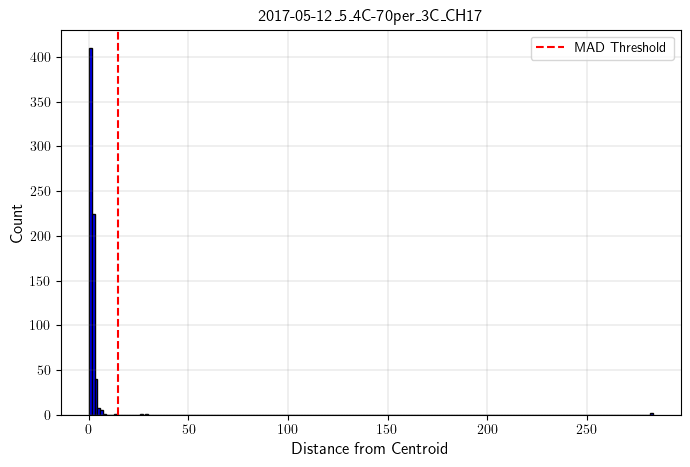

In [22]:
axplot = dbad.plot_hist_distance(distance=mahalanobis_dist, 
                        threshold=threshold)

axplot.set_title(selected_cell_label, fontsize=12)

filename=f"{metric_name}_histogram"

output_fig_filename = (
    filename + "_"
    + selected_cell_label
    + ".png")

fig_output_path = (
    selected_cell_artifacts.joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=200,
    bbox_inches="tight")

plt.show()

## Get df_outliers_pred

In [23]:
df_outliers_pred = df_features_per_cell[
    df_features_per_cell["cycle_index"].isin(pred_outlier_indices)].copy()

df_outliers_pred["outlier_distance"] = pred_outlier_distance

df_outliers_pred

,max_diff_dQ,log_max_diff_dQ,cycle_index,max_diff_dV,log_max_diff_dV,cell_index,outlier_distance
0,0.006388,-5.053343,0.0,1.564151,0.447343,2017-05-12_5_4C-70per_3C_CH17,25.975477
40,0.006305,-5.066425,40.0,2.612268,0.960219,2017-05-12_5_4C-70per_3C_CH17,29.112200
147,0.042814,-3.150895,147.0,0.029431,-3.525697,2017-05-12_5_4C-70per_3C_CH17,282.830852
148,0.042899,-3.148905,148.0,0.025238,-3.679404,2017-05-12_5_4C-70per_3C_CH17,283.011581


## Plot distance score mapping

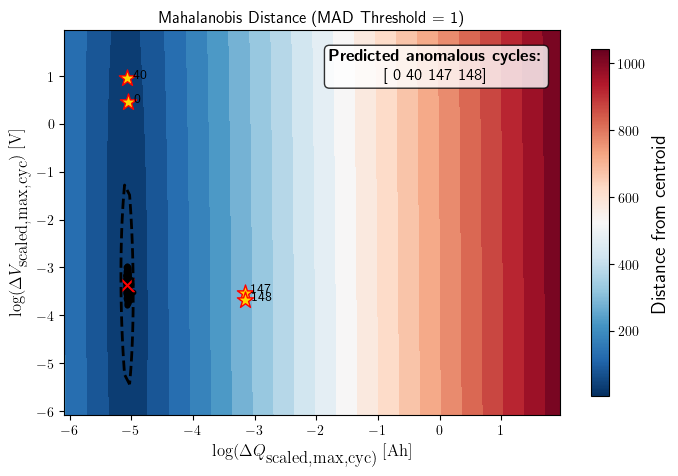

In [24]:
xx, yy, meshgrid = runner.create_2d_mesh_grid()

grid_mahalanobis_dist = dbad.calculate_distance(metric_name=metric_name,
                                        features=meshgrid,
                                        centroid=centroid,
                                        inv_cov_matrix=inv_cov_matrix,
                                        )
        
axplot = dbad.plot_distance_score_map(
        meshgrid_distance = grid_mahalanobis_dist,
        xx = xx,
        yy = yy,
        features=features,
        xoutliers= df_outliers_pred["log_max_diff_dQ"],
        youtliers= df_outliers_pred["log_max_diff_dV"],
        centroid=centroid,
        threshold= threshold,
        pred_outlier_indices=pred_outlier_indices,       
        #max_outlier_dist = max(pred_outlier_distance)
        )

axplot.set_title(f"Mahalanobis Distance (MAD Threshold = {1})", fontsize = 12)

filename = f"{metric_name}_dist_map_mad_thresh_1"

output_fig_filename = (
        filename + "_"
        + selected_cell_label
        + ".png")

fig_output_path = (selected_cell_artifacts.
                   joinpath(output_fig_filename))

plt.savefig(
        fig_output_path,
        dpi=200,
        bbox_inches="tight")

plt.show()

## Method Performance Evaluation

In [85]:
df_eval_outlier = modval.evaluate_pred_outliers(
    df_benchmark=df_selected_cell,
    outlier_cycle_index=pred_outlier_indices)

### Confusion Matrix

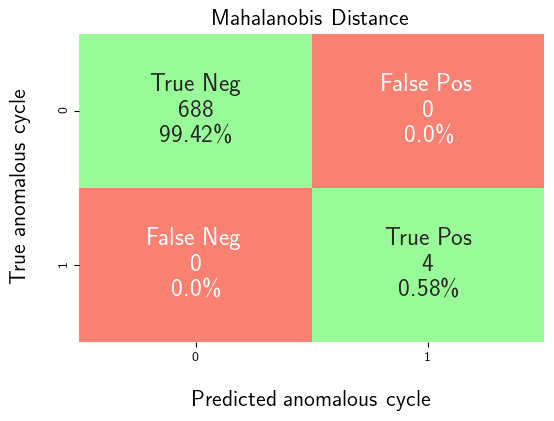

In [86]:
axplot = modval.generate_confusion_matrix(
    y_true=df_eval_outlier["true_outlier"],
    y_pred=df_eval_outlier["pred_outlier"])

axplot.set_title(
    "Mahalanobis Distance",
    fontsize=16)

output_fig_filename = (
    "conf_matrix_mahalanobis_"
    + selected_cell_label
    + ".png")

fig_output_path = (
    selected_cell_artifacts
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()